In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import clear_output

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import numpy as np

# plt.ion()  # turning interactive mode on

class gaussian_animator():
    def __init__(self, gaussian, figure, total_steps, x_limits=[-10,10], rng=np.random.default_rng()):
        self.gaussian = gaussian
        self.total_steps = total_steps
        self.rng = rng
        self.current_step = 0
        self.figure = figure
        self.x_limits = x_limits

    def draw(self, number):
        ax = self.figure.gca()
        ax.clear()

        # Draw the horizontal line
        ax.axhline(y=0, color='black', linewidth=2)

        # Draw the green transparent rectangle for correct limits
        correct_limits = [gaussian.mean - gaussian.correct_n_stds*gaussian.std,
                          gaussian.mean + gaussian.correct_n_stds*gaussian.std]
        ax.add_patch(
            plt.Rectangle(
                (correct_limits[0], -0.05),  # (x, y)
                correct_limits[1] - correct_limits[0],  # width
                0.1,  # height
                color='green',
                alpha=0.3,
                zorder=0
            )
        )
        if self.gaussian.is_within_stds(number):
            ax.text(
                (correct_limits[0] + correct_limits[1]) / 2, 0.15,
                'Correct guess',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12,
                color='green'
            )
            # Draw the red cross at the specified number
            ax.plot(number, 0, marker='o', color='green', markersize=12, markeredgewidth=3, label='Your guess')
        else:
            ax.text(
                (correct_limits[0] + correct_limits[1]) / 2, 0.15,
                'Incorrect guess',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12,
                color='red'
            )
            # Draw the red cross at the specified number
            ax.plot(number, 0, marker='x', color='red', markersize=12, markeredgewidth=3, label='Your guess')

        # Draw the Gaussian above the line
        x = np.linspace(gaussian.mean - 50*gaussian.std, gaussian.mean + 50*gaussian.std, 400)
        y = norm.pdf(x, gaussian.mean, gaussian.std)
        y = y / y.max() * 0.5 + 0.2  # Scale and shift up for visibility above the line
        ax.plot(x, y, color='blue', label='Gaussian')

        # Optionally, mark the mean of the Gaussian
        ax.plot(gaussian.mean, 0.2 + 0.5, marker='o', color='blue', markersize=8, label='Mean')

        # Formatting
        ax.set_ylim(-0.2, 1)
        # ax.set_xlim(mean - x_std_limits, mean + x_std_limits)
        ax.set_xlim(self.x_limits)
        ax.set_yticks([])
        ax.legend()
        # self.figure.canvas.draw() 

class NonStationaryGaussian:
    def __init__(self, mean=0.0, std=1.0, mean_drift_std=0.1, correct_n_stds=3, bounds=[-10,10], n_steps=300, rng=None):
        self.mean = mean
        self.std = std
        self.correct_n_stds = correct_n_stds
        self.mean_drift_std = mean_drift_std
        self.bounds = bounds
        self.rng = rng if rng is not None else np.random.default_rng()
        # self.figure = plt.figure(figsize=(6, 4))
        self.n_steps = n_steps
        self.animator = gaussian_animator(self, figure=plt.figure(figsize=(6, 4)), total_steps=self.n_steps, x_limits=[-10,10] , rng=np.random.default_rng(42))

    def sample(self):
        return self.rng.normal(self.mean, self.std)

    def step(self):
        # Slightly change the mean to simulate non-stationarity
        # self.mean += self.rng.normal(0, self.mean_drift_std)
        new_mean = self.mean + self.rng.choice([-self.mean_drift_std, self.mean_drift_std])
        self.mean = min(max(new_mean, self.bounds[0] + self.correct_n_stds * self.std), self.bounds[1] - self.correct_n_stds * self.std)  # Ensure mean stays within bounds
        
    def is_within_stds(self, value):
        """
        Check if a value is within n standard deviations from the mean.
        """
        return abs(value - self.mean) <= self.correct_n_stds * self.std
    
    # def animate(self, guess=None, steps=100, x_limits=[-10,10], n_stds=1):
    #     fig = self.figure

    #     def update(frame):
    #         mean = self.mean
    #         std = self.std
    #         self.animator.draw(guess, mean, std, x_limits=x_limits, n_stds=n_stds)

    #     ani = FuncAnimation(fig, update, frames=steps, repeat=False, interval=200)
    #     return ani
    


# delta rule with stationary gaussian

In [19]:

len_bins = 20
bins = np.linspace(-10, 10, len_bins + 1)  # Define bins for the Gaussian

guess = -9.5
current_state = np.digitize(guess, bins)

In [20]:
current_state

1

In [74]:
rng.uniform(bins[current_state-1],bins[current_state] ) # Width of the current bin

-9.591471356275363

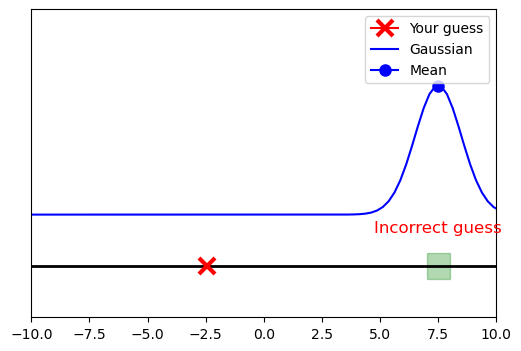

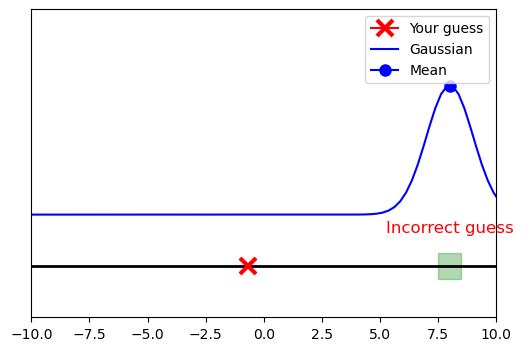

In [ ]:
#parameters
total_steps = 100000
rng = np.random.default_rng(42)
len_bins = 40
bins = np.linspace(-10, 10, len_bins + 1)  # Define bins for the Gaussian
q_value = np.zeros((len_bins,len_bins))
alpha = 0.95
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.999
min_epsilon = 0.01
gaussian = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.5, correct_n_stds=0.5, rng=rng)
# gaussian.figure.show()
guess = 0.5
rewards = np.zeros(total_steps+1)
# q_value[:,0,0] = initial_guess  # Initialize the first guess
for step in range(total_steps):
    current_state = np.digitize(guess, bins) - 1 #digitize enumerates buckets from 1
    if gaussian.is_within_stds(guess):
        reward = 1.0  # Correct guess, no reward
    else:
        reward = -1.0  # incorrect guess, negative reward
    
    next_state = rng.choice(range(len_bins)) if rng.random() < epsilon \
                else np.argmax(q_value[current_state, :])  # Choose the next state based on epsilon-greedy policy
                # else rng.choice(np.flatnonzero(q_value[current_state, :, step] == q_value[current_state, :, step].max()))
    next_guess = rng.uniform(bins[next_state],bins[next_state+1])

    rewards[step+1] = reward
    # Update the Q-table
    if step+1 < total_steps:
        q_value[current_state, next_state] = (1-alpha)*q_value[current_state, next_state] + alpha * (reward + gamma*np.max(q_value[next_state,:]))
    #draw
    if True and step > 99900:
        clear_output(wait=True)
        display(gaussian.animator.figure)
        gaussian.animator.draw(guess)
        print()
    # Update the Gaussian mean for the next step
    gaussian.step()

    guess = next_guess
    epsilon = max(min_epsilon, epsilon*epsilon_decay)

[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0

(0.0, 100000.0)

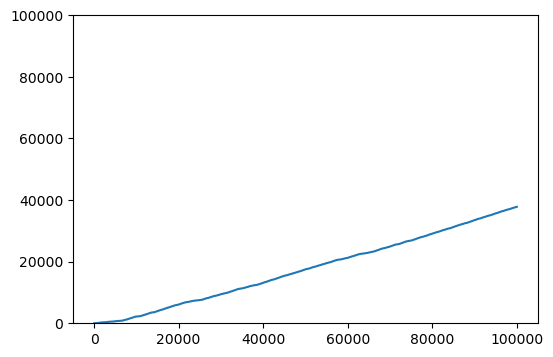

In [210]:

fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
positive_reward = [x if x > 0 else 0 for x in rewards ]
print(positive_reward)
cumulative_rewards = np.cumsum(positive_reward)
ax_rewards.plot(cumulative_rewards, label='Cumulative Rewards')
ax_rewards.set_ylim(0, total_steps)
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')

In [ ]:
# state = np.digitize(guess, bins) - 1
guess = rng.uniform(bins[0],bins[-1])
state = np.digitize(guess, bins) - 1  # digitize enumerates buckets from 1
# gaussian_2 = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.5, correct_n_stds=0.5, rng=rng)
for step in range(total_steps):
    clear_output(wait=True)
    gaussian.animator.draw(guess)
    # gaussian_2.animator.draw(guess)
    display(gaussian.animator.figure)
    # display(gaussian_2.animator.figure)
    # gaussian.step()
    # gaussian_2.step()
    state = np.argmax(q_value[state, :])
    guess = rng.uniform(bins[state],bins[state+1])

# delta rule with non-stationary gaussian

## testing gamma

In [3]:
n_episodes = 10
all_rewards = np.empty((n_episodes, total_steps+1))
gammas = np.linspace(0.8, 0.9999, n_episodes)
plt.ioff()
for episode in range(n_episodes):
    #parameters
    total_steps = 100000
    rng = np.random.default_rng(42)
    len_bins = 20
    bins = np.linspace(-10, 10, len_bins + 1)  # Define bins for the Gaussian
    q_value = np.zeros((len_bins,len_bins))
    alpha = 0.95
    gamma = gammas[episode]
    epsilon = 1.0
    epsilon_decay = 0.999
    min_epsilon = 0.01
    gaussian = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.5, correct_n_stds=0.5, rng=rng)
    # gaussian.figure.show()
    guess = 0.5
    rewards = np.zeros(total_steps+1)
    # q_value[:,0,0] = initial_guess  # Initialize the first guess
    for step in range(total_steps):
        current_state = np.digitize(guess, bins) - 1 #digitize enumerates buckets from 1
        # Sample from the non-stationary Gaussian
        # sample = gaussian.sample()
        # Check if the sample is within 1 standard deviation of the mean
        if gaussian.is_within_stds(guess):
            # print(f"Step {step}: Sample {q_value[step]} is within {n_stds} std of the mean.")
            reward = 1.0  # Correct guess, no reward
        else:
            # print(f"Step {step}: Sample {q_value[step]} is outside {n_stds} std of the mean.")
            reward = -1.0  # incorrect guess, negative reward
        
        next_state = rng.choice(range(len_bins)) if rng.random() < epsilon \
                    else np.argmax(q_value[current_state, :])  # Choose the next state based on epsilon-greedy policy
                    # else rng.choice(np.flatnonzero(q_value[current_state, :, step] == q_value[current_state, :, step].max()))
        next_guess = rng.uniform(bins[next_state],bins[next_state+1])

        rewards[step+1] = reward
        # Update the Q-table
        if step+1 < total_steps:
            q_value[current_state, next_state] = (1-alpha)*q_value[current_state, next_state] + alpha * (reward + gamma*np.max(q_value[next_state,:]))
            # if reward < 0:
            #     q_value[step+1] = q_value[step] + alpha * (gamma**step*reward - q_value[step])
            # else:
            #     q_value[step+1] = q_value[step]
        #draw
        if True and step > 99950:
            clear_output(wait=True)
            display(gaussian.animator.figure)
            gaussian.animator.draw(guess)
        # Update the Gaussian mean for the next step
        gaussian.step()

        guess = next_guess
        epsilon = max(min_epsilon, epsilon*epsilon_decay)
        # time.sleep(0.01)
    all_rewards[episode,:] = rewards


NameError: name 'total_steps' is not defined

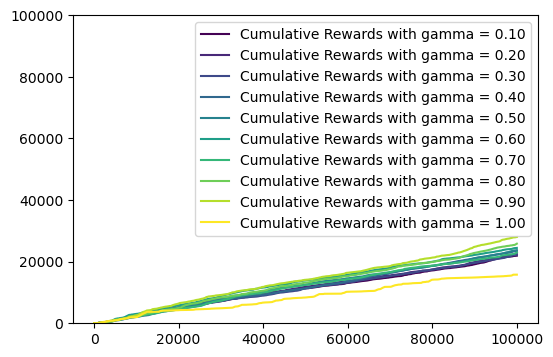

In [220]:

import matplotlib.cm as cm

fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
ax_rewards.set_ylim(0, total_steps)
colors = cm.viridis(np.linspace(0, 1, n_episodes))
for episode in range(n_episodes):
    positive_reward = [x if x > 0 else 0 for x in all_rewards[episode,:] ]
    # print(positive_reward)
    cumulative_rewards = np.cumsum(positive_reward)
    ax_rewards.plot(cumulative_rewards, label=f'Cumulative Rewards with gamma = {gammas[episode]:.2f}', color=colors[episode])
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')
ax_rewards.legend()

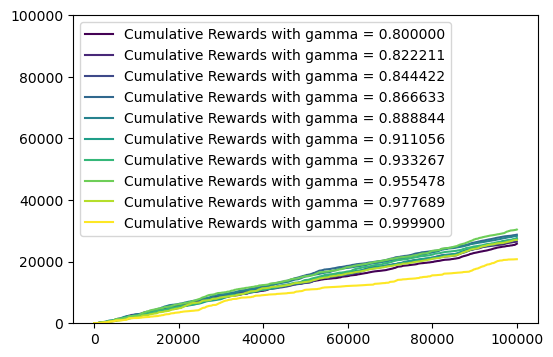

In [227]:

import matplotlib.cm as cm
plt.ion()
fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
ax_rewards.set_ylim(0, total_steps)
colors = cm.viridis(np.linspace(0, 1, n_episodes))
for episode in range(n_episodes):
    positive_reward = [x if x > 0 else 0 for x in all_rewards[episode,:] ]
    # print(positive_reward)
    cumulative_rewards = np.cumsum(positive_reward)
    ax_rewards.plot(cumulative_rewards, label=f'Cumulative Rewards with gamma = {gammas[episode]:.6f}', color=colors[episode])
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')
ax_rewards.legend()

## testing alpha

In [ ]:
n_episodes = 10
all_rewards = np.empty((n_episodes, total_steps+1))
alphas = np.linspace(0.9,0.9999, n_episodes)
for episode in range(n_episodes):
    #parameters
    total_steps = 100000
    rng = np.random.default_rng(42)
    len_bins = 20
    bins = np.linspace(-10, 10, len_bins + 1)  # Define bins for the Gaussian
    q_value = np.zeros((len_bins,len_bins))
    alpha = alphas[episode]
    gamma = .955488
    epsilon = 1.0
    epsilon_decay = 0.999
    min_epsilon = 0.01
    gaussian = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.05, correct_n_stds=0.5, rng=rng)
    # gaussian.figure.show()
    guess = 0.5
    rewards = np.zeros(total_steps+1)
    # q_value[:,0,0] = initial_guess  # Initialize the first guess
    for step in range(total_steps):
        current_state = np.digitize(guess, bins) - 1 #digitize enumerates buckets from 1
        # Sample from the non-stationary Gaussian
        # sample = gaussian.sample()
        # Check if the sample is within 1 standard deviation of the mean
        if gaussian.is_within_stds(guess):
            # print(f"Step {step}: Sample {q_value[step]} is within {n_stds} std of the mean.")
            reward = 1.0  # Correct guess, no reward
        else:
            # print(f"Step {step}: Sample {q_value[step]} is outside {n_stds} std of the mean.")
            reward = -1.0  # incorrect guess, negative reward
        
        next_state = rng.choice(range(len_bins)) if rng.random() < epsilon \
                    else np.argmax(q_value[current_state, :])  # Choose the next state based on epsilon-greedy policy
                    # else rng.choice(np.flatnonzero(q_value[current_state, :, step] == q_value[current_state, :, step].max()))
        next_guess = rng.uniform(bins[next_state],bins[next_state+1])

        rewards[step+1] = reward
        # Update the Q-table
        if step+1 < total_steps:
            q_value[current_state, next_state] = (1-alpha)*q_value[current_state, next_state] + alpha * (reward + gamma*np.max(q_value[next_state,:]))
            # if reward < 0:
            #     q_value[step+1] = q_value[step] + alpha * (gamma**step*reward - q_value[step])
            # else:
            #     q_value[step+1] = q_value[step]
        #draw
        if False and step > 99950:
            clear_output(wait=True)
            display(gaussian.animator.figure)
            gaussian.animator.draw(guess)
        # Update the Gaussian mean for the next step
        gaussian.step()

        guess = next_guess
        epsilon = max(min_epsilon, epsilon*epsilon_decay)
        # time.sleep(0.01)
    all_rewards[episode,:] = rewards


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

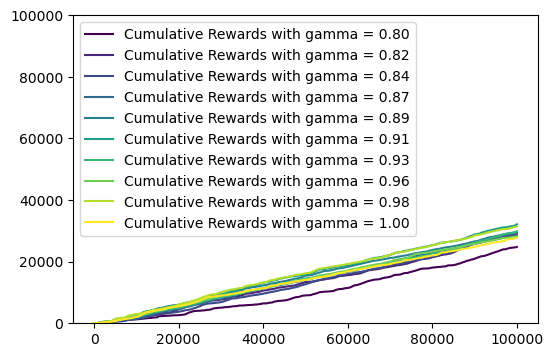

In [230]:

import matplotlib.cm as cm
plt.ion()
fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
ax_rewards.set_ylim(0, total_steps)
colors = cm.viridis(np.linspace(0, 1, n_episodes))
for episode in range(n_episodes):
    positive_reward = [x if x > 0 else 0 for x in all_rewards[episode,:] ]
    # print(positive_reward)
    cumulative_rewards = np.cumsum(positive_reward)
    ax_rewards.plot(cumulative_rewards, label=f'Cumulative Rewards with gamma = {gammas[episode]:.2f}', color=colors[episode])
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')
ax_rewards.legend()

the legend is wrong. but the curves are good (I used theold  gammas instead of alpha by accident )

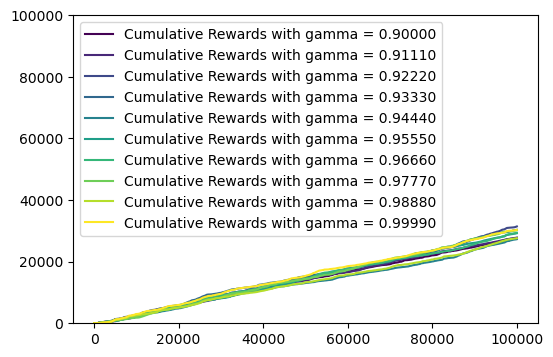

In [233]:

import matplotlib.cm as cm
plt.ion()
fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
ax_rewards.set_ylim(0, total_steps)
colors = cm.viridis(np.linspace(0, 1, n_episodes))
for episode in range(n_episodes):
    positive_reward = [x if x > 0 else 0 for x in all_rewards[episode,:] ]
    # print(positive_reward)
    cumulative_rewards = np.cumsum(positive_reward)
    ax_rewards.plot(cumulative_rewards, label=f'Cumulative Rewards with gamma = {alphas[episode]:.5f}', color=colors[episode])
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')
ax_rewards.legend()

## optimal

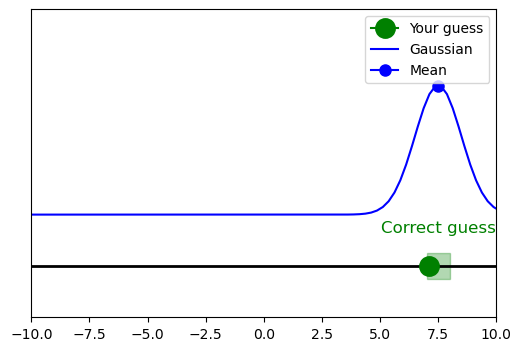

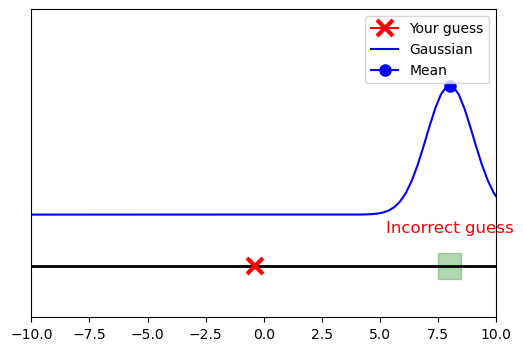

In [ ]:

#parameters
total_steps = 100000
rng = np.random.default_rng(42)
len_bins = 20
bins = np.linspace(-10, 10, len_bins + 1)  # Define bins for the Gaussian
q_value = np.zeros((len_bins,len_bins))
alpha = 0.9222
gamma = 0.955488
epsilon = 1.0
epsilon_decay = 0.999
min_epsilon = 0.01
gaussian = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.05, correct_n_stds=0.5, rng=rng)
# gaussian.figure.show()
guess = 0.5
rewards = np.zeros(total_steps+1)
# q_value[:,0,0] = initial_guess  # Initialize the first guess
for step in range(total_steps):
    current_state = np.digitize(guess, bins) - 1 #digitize enumerates buckets from 1
    # Sample from the non-stationary Gaussian
    # sample = gaussian.sample()
    # Check if the sample is within 1 standard deviation of the mean
    if gaussian.is_within_stds(guess):
        # print(f"Step {step}: Sample {q_value[step]} is within {n_stds} std of the mean.")
        reward = 1.0  # Correct guess, no reward
    else:
        # print(f"Step {step}: Sample {q_value[step]} is outside {n_stds} std of the mean.")
        reward = -1.0  # incorrect guess, negative reward
    
    next_state = rng.choice(range(len_bins)) if rng.random() < epsilon \
                else np.argmax(q_value[current_state, :])  # Choose the next state based on epsilon-greedy policy
                # else rng.choice(np.flatnonzero(q_value[current_state, :, step] == q_value[current_state, :, step].max()))
    next_guess = rng.uniform(bins[next_state],bins[next_state+1])

    rewards[step+1] = reward
    # Update the Q-table
    if step+1 < total_steps:
        q_value[current_state, next_state] = (1-alpha)*q_value[current_state, next_state] + alpha * (reward + gamma*np.max(q_value[next_state,:]))
        # if reward < 0:
        #     q_value[step+1] = q_value[step] + alpha * (gamma**step*reward - q_value[step])
        # else:
        #     q_value[step+1] = q_value[step]
    #draw
    if True and step > 99950:
        clear_output(wait=True)
        display(gaussian.animator.figure)
        gaussian.animator.draw(guess)
    # Update the Gaussian mean for the next step
    gaussian.step()

    guess = next_guess
    epsilon = max(min_epsilon, epsilon*epsilon_decay)
    # time.sleep(0.01)


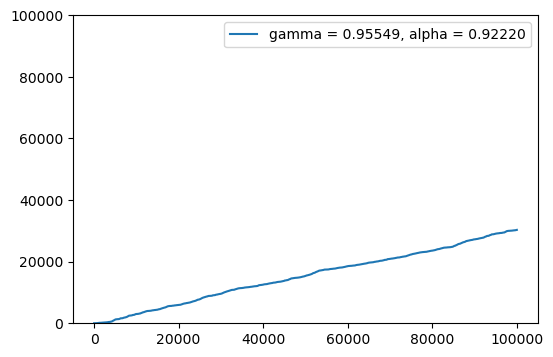

In [235]:

import matplotlib.cm as cm
plt.ion()
fig_rewards, ax_rewards = plt.subplots(figsize=(6, 4))
ax_rewards.set_ylim(0, total_steps)
positive_reward = [x if x > 0 else 0 for x in all_rewards[episode,:] ]
# print(positive_reward)
cumulative_rewards = np.cumsum(positive_reward)
ax_rewards.plot(cumulative_rewards, label=f'gamma = {gamma:.5f}, alpha = {alpha:.5f}')
# ax_rewards.scatter(list(range(len(rewards))),rewards, label='Rewards')
ax_rewards.legend()

# Foraging

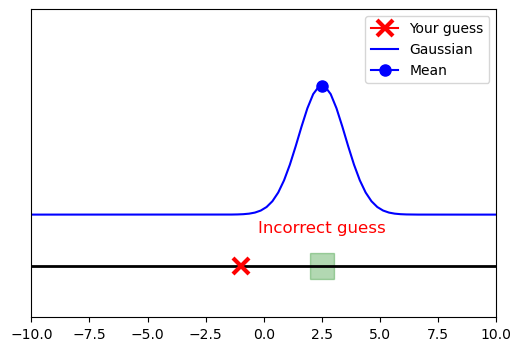

In [ ]:
class foraging_scenario():
    def __init__(self, gaussian, gaussian_animator):
        self.gaussian = gaussian
        self.self.animator = gaussian_animator
        self.total_steps = 300
        self.rng = np.random.default_rng(42)
        self.q_value = np.empty((total_steps))
        self.alpha = 0.1

        def explore(self):
            # This method can be used to implement exploration strategies
            pass

gaussian = NonStationaryGaussian(mean=0.0, std=1.0, mean_drift_std=0.5, correct_n_stds=0.5, rng=rng)
# gaussian.figure.show()
initial_guess = 0.5
q_value[0] = initial_guess  # Initialize the first guess
for step in range(total_steps):
    # Sample from the non-stationary Gaussian
    # sample = gaussian.sample()
    # Check if the sample is within 1 standard deviation of the mean
    if gaussian.is_within_stds(q_value[step]):
        # print(f"Step {step}: Sample {q_value[step]} is within {n_stds} std of the mean.")
        reward = 0  # Correct guess, no reward
    else:
        # print(f"Step {step}: Sample {q_value[step]} is outside {n_stds} std of the mean.")
        reward = -1.0  # incorrect guess, negative reward
    
    # Update the Q-table
    if step+1 < total_steps:
        if reward < 0:
            q_value[step+1] = q_value[step] + alpha * (reward - q_value[step])
        else:
            q_value[step+1] = q_value[step]
    
    # Update the Gaussian mean for the next step
    gaussian.step()
    # gaussian.animate(guess=q_value[step], steps=total_steps)
    gaussian.animator.draw(q_value[step])
    # gaussian.figure.canvas.flush_events()
    clear_output(wait=True)
    display(gaussian.animator.figure)
    # time.sleep(0.01)